In [66]:
import glob 
import os
import pickle
import numpy as np
import torch
from torch.nn import functional as F
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt

from cca import *

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 20
plt.rcParams['font.weight'] = 'normal'
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['text.usetex'] = False

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
HOME_PATH = os.path.expanduser('~')
DATA_PATH = os.path.join(HOME_PATH, 'Datasets/CUB/')

In [4]:
true_img_ft = torch.load('true_data_img_feature.pt').to(device, dtype=torch.float32)
true_sent_emb = torch.load('true_data_sent_embedding.pt').to(device, dtype=torch.float32)
true_img_mean = true_img_ft.mean(dim=0)
true_txt_mean = true_sent_emb.mean(dim=0)

In [5]:
PC = torch.load('sentence_emb_PC.pt').to(device, dtype=torch.float32)

In [6]:
# corr, (img_cca, txt_cca) = cca([true_img_ft, true_sent_emb], k=40)

In [7]:
# torch.save(img_cca, 'true_data_img_feature_cca.pt')
# torch.save(txt_cca, 'true_data_sent_embedding_cca.pt')
img_cca = torch.load('true_data_img_feature_cca.pt').to(device)
txt_cca = torch.load('true_data_sent_embedding_cca.pt').to(device)

In [72]:
true_corr = calculate_corr(true_img_ft, true_sent_emb, true_img_mean, true_txt_mean, img_cca, txt_cca)
true_corr

tensor(0.1416, device='cuda:0')

In [68]:
from torch.distributions import Laplace
import poisevae
from poisevae.datasets import CUB
from poisevae.utils import NN_lookup, Categorical, sent_emb
from poisevae.networks.CUBNetworks import EncImg, DecImg, EncTxt, DecTxt

In [10]:
tx = lambda data: torch.Tensor(data)
CUB_test = CUB(DATA_PATH, DATA_PATH, 'test', device, tx, return_idx=True)

In [11]:
vocab_size, txt_len = CUB_test.CUBtxt.vocab_size, CUB_test.CUBtxt.max_sequence_length
vocab_size, txt_len

(1590, 32)

In [12]:
enc_img = EncImg(128).to(device)
dec_img = DecImg(128).to(device)
enc_txt = EncTxt(vocab_size, 128).to(device)
dec_txt = DecTxt(vocab_size, 128).to(device)
vae = poisevae.POISEVAE([enc_img, enc_txt], [dec_img, dec_txt], likelihoods=[Laplace, Categorical], 
                        latent_dims=[128, (128, 1, 1)]).to(device)
vae, optimizer, epoch = poisevae.utils.load_checkpoint(vae, load_path=sorted(glob.glob('../example/runs/CUB/wrew/train*.pt'))[-1])
epoch

50

In [43]:
CUB_train = CUB(DATA_PATH, DATA_PATH, 'train', device, tx, return_idx=True)
test_loader = torch.utils.data.DataLoader(CUB_train, batch_size=128, shuffle=True)

In [70]:
with open(os.path.join(DATA_PATH, 'cub/oc:3_msl:32/cub.emb'), 'rb') as file:
    emb = pickle.load(file)
with open(os.path.join(DATA_PATH, 'cub/oc:3_msl:32/cub.weights'), 'rb') as file:
    weights = pickle.load(file)

In [44]:
txt_rec_emb = []
img_rec = []
with torch.no_grad():
    for i, (img, txt, idx) in enumerate(test_loader):
        results = vae([img.to(device), txt.to(device)])
        
        img_rec_i = results['x_rec'][0].loc
        img_rec.append(img_rec_i)
        
        txt_rec_i = results['x_rec'][1].probs.argmax(dim=1).reshape(img_rec_i.shape[0], -1)
        txt_rec_emb.append(np.zeros((img_rec_i.shape[0], emb.shape[1])))
        sent_emb(txt_rec_i.cpu().numpy().astype(np.int32), emb, weights, txt_rec_emb[-1])
        if i >= 15:
            break
            
img_rec = torch.cat(img_rec).to(device, torch.float32)
txt_rec_emb = torch.tensor(np.vstack(txt_rec_emb)).to(device, torch.float32)

In [45]:
txt_rec_emb = pca_transform(txt_rec_emb, PC)

In [46]:
calculate_corr(img_rec, txt_rec_emb, true_img_mean, true_txt_mean, img_cca, txt_cca)

tensor(6.5780e-05, device='cuda:0')

In [75]:
full_txt_data = torch.cat([d[1] for d in test_loader]).detach().cpu().numpy().astype(np.int32)
output = np.zeros((full_txt_data.shape[0], emb.shape[1]))
full_img_data = torch.cat([d[0] for d in test_loader])
sent_emb(full_txt_data, emb, weights, output)
output = torch.tensor(output).to(device, torch.float32)
_, _, V = torch.svd(output - output.mean(axis=0))
v = V[:, 0].unsqueeze(-1)
PC = v.mm(v.t())
output = pca_transform(output, PC)
calculate_corr(full_img_data.to(device, torch.float32), output, 
               true_img_mean, true_txt_mean, img_cca, txt_cca)

tensor(0.0009, device='cuda:0')

In [26]:
with torch.no_grad():
    for i, (img, txt, idx) in enumerate(test_loader):
        results = vae([img.to(device), txt.to(device)])
        x_rec = results['x_rec']
        x_rec = [x_rec[0].loc, x_rec[1].probs.argmax(dim=1).reshape(x_rec[0].loc.shape[0], -1)]
        dist, idx_h = NN_lookup(x_rec[0], img)
        # dist, idx_h = NN_lookup(results['x_rec'][0], img)
        imgs_h = [CUB_test.CUBimg.dataset[int(idx[j]) // 10][0] for j in idx_h]
        imgs = [CUB_test.CUBimg.dataset[int(j) // 10][0] for j in idx]
        txts = [CUB_test.CUBtxt.data[str(int(j))] for j in idx]
        break

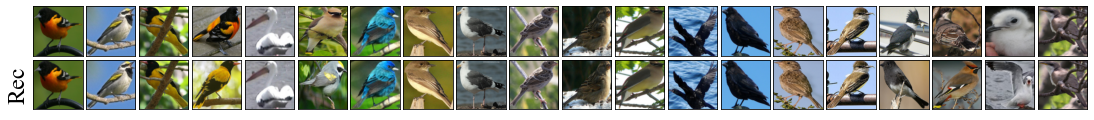

In [27]:
ncols = min(len(imgs_h), 20)
fig, ax = plt.subplots(nrows=2, ncols=ncols, figsize=(15, 1.5))
for i, aux in enumerate(zip(imgs, imgs_h)):
    if i >= ncols:
        break
    for j, im in enumerate(aux):
        ax[j, i].imshow(im.permute(1, 2, 0))
        ax[j, i].set_xticks([])
        ax[j, i].set_yticks([])
ax[1, 0].set_ylabel('Rec', fontsize=24)
fig.tight_layout(pad=0)

In [28]:
sents_h = []
sents_emb = x_rec[1]
for se in sents_emb:
    sent_h = []
    for j in se:
        char = CUB_test.CUBtxt.i2w[str(int(j.item()))]
        if char == '<eos>':
            break
        sent_h.append(char)
    sents_h.append(' '.join(sent_h))

sents = []
for i, sent_h in enumerate(sents_h):
    sent = []
    for char in txts[i]['tok']:
        if char == '<eos>':
            break
        sent.append(char)
    sents.append(' '.join(sent))

In [29]:
for sent, sent_h in zip(sents, sents_h):
    print('     ', sent)
    print('Rec: ', sent_h)

      this bird is orange with black on its head and has a long , pointy beak .
Rec:  this bird is orange with black on its crown and has a long , pointy beak .
      this bird has a white breast and a yellow black and white crown .
Rec:  this bird has a white breast and a yellow black and white crown .
      this bird has a red beak and black feathers around its head , but bright orange feathers covering the majority of its body .
Rec:  this bird has a red beak and black ring around its head , and bright orange feathers on the majority of its body .
      black , orange , and yellow bird with a small head and beak .
Rec:  black , black , and yellow bird with a small head and beak .
      this bird has wings that are white and has a yellow belly .
Rec:  this bird has wings that are white and has a yellow belly .
      a round bird with a white body , red tinted head with a black stripe across its eyes and a tiny head .
Rec:  a round bird with a white body , red body , with a black stri